# Đề tài: Phân tích cảm nghĩ người dùng về sản phẩm công nghệ trên Reddit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install asyncpraw emoji contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import string
import os
import warnings
import emoji
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
import pickle
warnings.filterwarnings('ignore')

## 1. Chuẩn bị dữ liệu

### 1.1. Thu thập dữ liệu

In [ ]:
import asyncpraw  # Sử dụng cho colab
import asyncio
import pandas as pd

# Tách luồng riêng
import nest_asyncio
nest_asyncio.apply()

async def collect_reddit_data():
    # Thiết lập kết nối với Reddit
    reddit = asyncpraw.Reddit(
        client_id="vawf1ksMlZvt40z5fPQnOg",
        client_secret="xEPH62kQkyHBhIUEL30wIzC1A7rrww",
        user_agent='user sentiment analysis'
    )

    # Danh sách các từ khóa tìm kiếm
    brands = ['iPhone', 'Samsung', 'Xiaomi']

    # Hàm kiểm tra xem bình luận có chứa từ khóa nào không
    def get_brand_from_text(text, brands):
        for brand in brands:
            if brand.lower() in text.lower():
                return brand
        return None

    # Danh sách các subreddit
    subreddits = ['technology', 'gadgets', 'android', 'apple', 'smartphones']
    comments_data = []

    for subreddit_name in subreddits:
        print(f"Đang thu thập từ r/{subreddit_name}...")
        subreddit = await reddit.subreddit(subreddit_name)

        # Chỉ thu thập bài viết HOT
        print(f"  Đang thu thập bài viết hot...")
        async for post in subreddit.hot(limit=100):
            try:
                # Nạp lại post để chắc chắn có đủ dữ liệu
                post = await reddit.submission(id=post.id)

                print(f"    Đang thu thập bình luận từ bài viết: {post.title[:50]}...")

                # Mở rộng "load more" và lấy tất cả comment
                await post.comments.replace_more(limit=10)
                all_comments = post.comments.list()

                # Duyệt qua từng comment
                for comment in all_comments:
                    if hasattr(comment, 'body'):
                        brand = get_brand_from_text(comment.body, brands)
                        if brand:
                            try:
                                author_name = comment.author.name if comment.author else 'deleted'
                            except:
                                author_name = 'deleted'

                            comments_data.append({
                                'brand': brand,
                                'subreddit': subreddit_name,
                                'post_id': post.id,
                                'post_title': post.title,
                                'comment_id': comment.id,
                                'comment_body': comment.body,
                                'comment_author': author_name,
                                'comment_score': comment.score,
                                'comment_time': comment.created_utc
                            })

                print(f"    Đã thu thập {len(all_comments)} bình luận, tìm thấy {sum(1 for c in comments_data if c['post_id'] == post.id)} bình luận có thương hiệu")

            except Exception as e:
                print(f"    Lỗi khi thu thập bài viết: {str(e)}")
                continue

    # In thử 5 comment đầu tiên
    print("\nMẫu dữ liệu thu thập được:")
    for i, comment in enumerate(comments_data[:5]):
        print(f"{i+1}. Brand: {comment['brand']} (r/{comment['subreddit']})\n{comment['comment_body'][:100]}...\n")

    # Lưu vào CSV
    df = pd.DataFrame(comments_data)
    df.to_csv('/content/drive/MyDrive/BTL_Data Mining/Dataset/raw/reddit_comments.csv', index=False)
    print(f"Đã lưu {len(df)} bình luận vào file reddit_comments.csv")

    await reddit.close()
    return df

# Chạy hàm thu thập
async def main():
    print("Bắt đầu thu thập dữ liệu từ Reddit...")
    df = await collect_reddit_data()
    print(f"Hoàn thành! Đã thu thập tổng cộng {len(df)} bình luận.")

# Chạy trong môi trường local
if __name__ == "__main__":
    loop = asyncio.get_event_loop()
    loop.run_until_complete(main())


Bắt đầu thu thập dữ liệu từ Reddit...
Đang thu thập từ r/technology...
  Đang thu thập bài viết hot...
    Đang thu thập bình luận từ bài viết: 4Chan hacked; Taken down; Emails and IPs leaked...
    Đã thu thập 1300 bình luận, tìm thấy 0 bình luận có thương hiệu
    Đang thu thập bình luận từ bài viết: EU gives staff 'burner phones, laptops' for US vis...
    Đã thu thập 144 bình luận, tìm thấy 0 bình luận có thương hiệu
    Đang thu thập bình luận từ bài viết: Mark Zuckerberg considered deleting everyone's Fac...
    Đã thu thập 342 bình luận, tìm thấy 0 bình luận có thương hiệu
    Đang thu thập bình luận từ bài viết: After Harvard says no to feds, $2.2 billion of res...
    Đã thu thập 184 bình luận, tìm thấy 0 bình luận có thương hiệu
    Đang thu thập bình luận từ bài viết: ‘Silicon Six’ accused of avoiding almost $278bn in...
    Đã thu thập 644 bình luận, tìm thấy 0 bình luận có thương hiệu
    Đang thu thập bình luận từ bài viết: Trump administration will ask Congress to cut fu

### 1.2. Tìm hiểu dữ liệu

In [179]:
df = pd.read_csv('/content/drive/MyDrive/BTL_Data_Mining/Dataset/raw/reddit_comments.csv')

In [180]:
# Display first few rows
print("Dataset preview:")
df.head()

Dataset preview:


,brand,subreddit,post_id,post_title,comment_id,comment_body,comment_author,comment_score,comment_time
0,iPhone,technology,1jz8a7h,"Facebook isn't really for friends anymore, Mar...",mn6elqr,Has anyone else noticed that FB now suggests *...,Wonderful-Bid9471,1,1.744688e+09
1,iPhone,technology,1jzq9em,"Trump Exempts Tech Gear From Huge Tariffs, Tem...",mn81bue,Anyone not rich enough to buy an iPhone gets t...,Suspicious-Town-7688,3,1.744720e+09
2,Samsung,technology,1jyy5ah,Microsoft warns that anyone who deleted myster...,mn5u1fd,Reddit has been total shit since whatever they...,AnonymousBanana7,3,1.744680e+09
3,iPhone,technology,1jzimiv,"Microsoft OneDrive file sync apps for Windows,...",mn8kv6f,If you’re on Mac and likely to have a iPhone f...,Noname_Maddox,1,1.744727e+09
4,iPhone,technology,1jyz3h0,She was chatting with friends in a Lyft. Then ...,mn45riy,Considering she said that a “driver is not ava...,FISHING_100000000000,141,1.744660e+09


In [181]:
# Dataset information
print("\nDataset information:")
df.info()


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           2550 non-null   object 
 1   subreddit       2550 non-null   object 
 2   post_id         2550 non-null   object 
 3   post_title      2550 non-null   object 
 4   comment_id      2550 non-null   object 
 5   comment_body    2550 non-null   object 
 6   comment_author  2550 non-null   object 
 7   comment_score   2550 non-null   int64  
 8   comment_time    2550 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 179.4+ KB


In [182]:
# Statistical summary
print("\nStatistical summary:")
print(df.describe())


Statistical summary:
       comment_score  comment_time
count    2550.000000  2.550000e+03
mean       15.354118  1.743994e+09
std        99.123133  9.699403e+05
min       -43.000000  1.739932e+09
25%         1.000000  1.743858e+09
50%         1.000000  1.744241e+09
75%         5.000000  1.744551e+09
max      2456.000000  1.744741e+09


In [183]:
# 1. Missing Values
print("\n----- Missing Values Analysis -----")
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print("\nMissing values by column:")
    print(missing_values[missing_values > 0])


----- Missing Values Analysis -----
Total missing values: 0


In [184]:
# 2. Duplicate Detection
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")


Duplicate rows: 0 (0.00%)


In [185]:
# 3. Comments per brand
brand_counts = df['brand'].value_counts()
print("\nComments per brand:")
print(brand_counts)


Comments per brand:
brand
iPhone     1876
Samsung     606
Xiaomi       68
Name: count, dtype: int64


In [186]:
# 4. Comments per subreddit
subreddit_counts = df['subreddit'].value_counts()
print("\nComments per subreddit:")
print(subreddit_counts)


Comments per subreddit:
subreddit
apple          1536
gadgets         362
android         298
smartphones     292
technology       62
Name: count, dtype: int64


In [187]:
# 5. Comment length statistics
df['comment_length'] = df['comment_body'].apply(len)
df['word_count'] = df['comment_body'].apply(lambda x: len(str(x).split()))

print("\nComment length statistics:")
print(df[['comment_length', 'word_count']].describe())


Comment length statistics:
       comment_length   word_count
count     2550.000000  2550.000000
mean       327.807451    57.696471
std        435.705936    73.257348
min          8.000000     1.000000
25%        100.000000    19.000000
50%        203.000000    37.000000
75%        384.000000    69.000000
max       6734.000000  1076.000000


In [188]:
# 8. Distribution check for extremely short or long comments
short_comments = len(df[df['word_count'] < 5])
long_comments = len(df[df['word_count'] > 200])
print(f"\nExtremely short comments (<5 words): {short_comments} ({short_comments/len(df)*100:.2f}%)")
print(f"Extremely long comments (>200 words): {long_comments} ({long_comments/len(df)*100:.2f}%)")


Extremely short comments (<5 words): 51 (2.00%)
Extremely long comments (>200 words): 98 (3.84%)


In [189]:
# 9. Sample of comments
print("\n----- Sample Comments -----")
for brand in df['brand'].unique():
    print(f"\nSample comments for {brand}:")
    samples = df[df['brand'] == brand].sample(min(3, len(df[df['brand'] == brand])))
    for _, row in samples.iterrows():
        print(f"- {row['comment_body'][:100]}...")


----- Sample Comments -----

Sample comments for iPhone:
- All of those are third party apps though. Once the AT&T exclusivity ended with the 4s and way more o...
- Those are basic functions no one is excited about. Phones within the iPhone’s price point can scroll...
- Was thinking about waiting until the end of the year to upgrade to an iPhone 17, but with the tariff...

Sample comments for Samsung:
- So many Beta versions with months of delay and STILL such shit happens.

Well done Samsung....
- I switched to samsung from pixel because I didn't need the updates so fast...little did I know...
- I'll be honest, I would love for Apple (and Samsung) to go to two year cycles. That would afford the...

Sample comments for Xiaomi:
- Xiaomi Redmi Note 14 Pro 5G for sure...
- Xiaomi Redmi K80 Pro

OnePlus Ace 5 Pro

Realme GT7 Pro Racing...
- Can't speak for previous iterations of Xiaomi Ultra, but 15 is balanced in the center despite the ma...


In [190]:
# 10. Top posts with most comments
post_counts = df.groupby(['post_id', 'post_title']).size().reset_index(name='comment_count')
top_posts = post_counts.sort_values('comment_count', ascending=False).head(10)
print("\nTop 10 posts with most comments:")
for _, row in top_posts.iterrows():
    print(f"- {row['post_title'][:50]}... ({row['comment_count']} comments)")


Top 10 posts with most comments:
- iPhones Could Cost Up to $2,300 in the U.S. Due to... (124 comments)
- Teen iPhone Ownership Continues to Soar... (119 comments)
- Apple iPhone Price Hikes Are Now Looking Possible ... (90 comments)
- Apple is racing to fly planes of iPhones into the ... (82 comments)
- Samsung admits a bad software update has been bric... (78 comments)
- A 'US-Made iPhone' Is Pure Fantasy... (67 comments)
- Trump Believes Apple Could Manufacture iPhones in ... (66 comments)
- Apple Planning 'Bold' New 20th Anniversary Design ... (59 comments)
- Apple launches the iPhone 16E... (59 comments)
- Breaking: One UI 7 update halted worldwide - Andro... (56 comments)


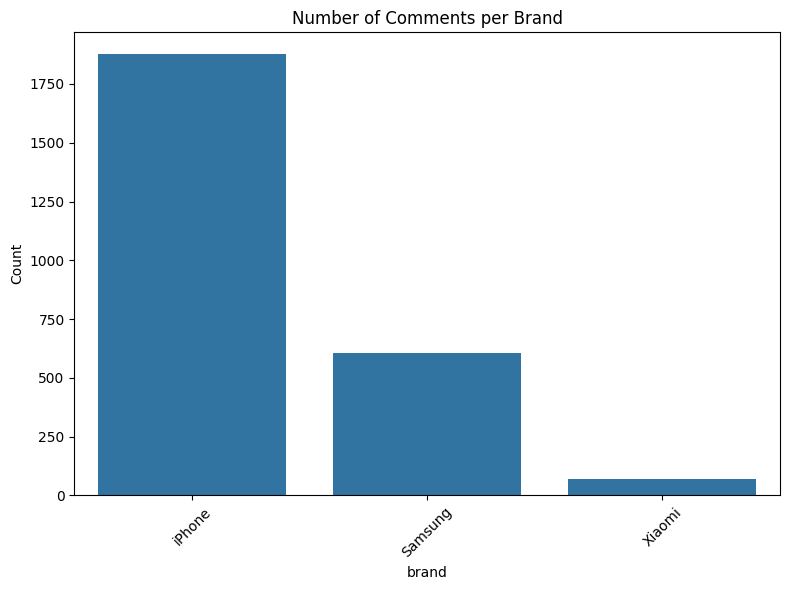

In [191]:
# Plot 1: Comments per brand
plt.figure(figsize=(8, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values)
plt.title('Number of Comments per Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

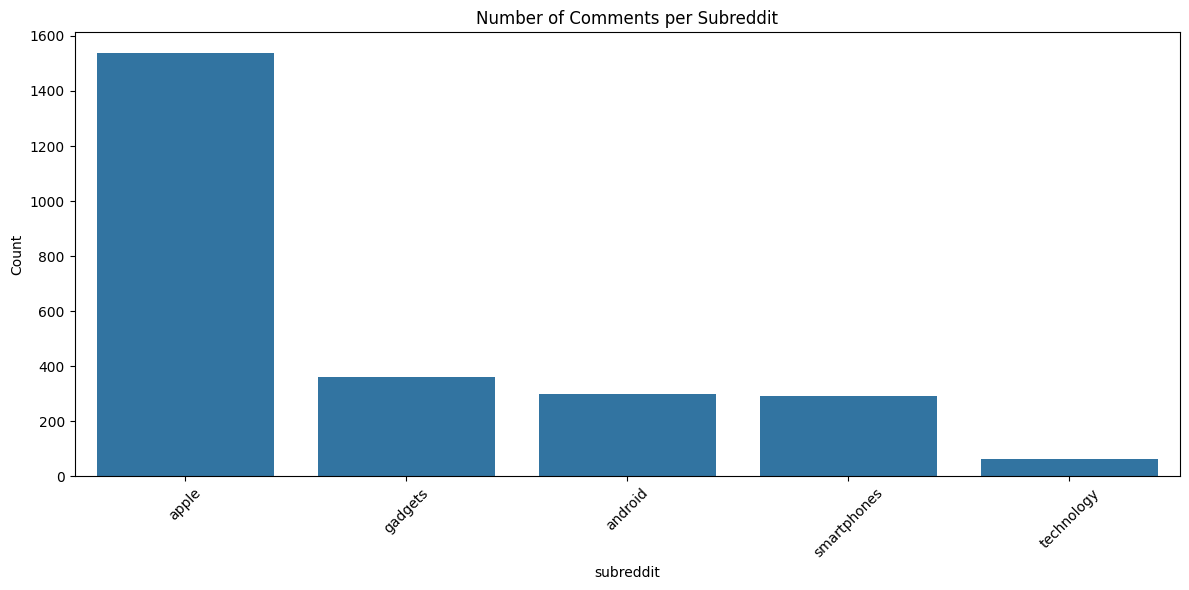

In [192]:
# Plot 2: Comments per subreddit
plt.figure(figsize=(12, 6))
sns.barplot(x=subreddit_counts.index, y=subreddit_counts.values)
plt.title('Number of Comments per Subreddit')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

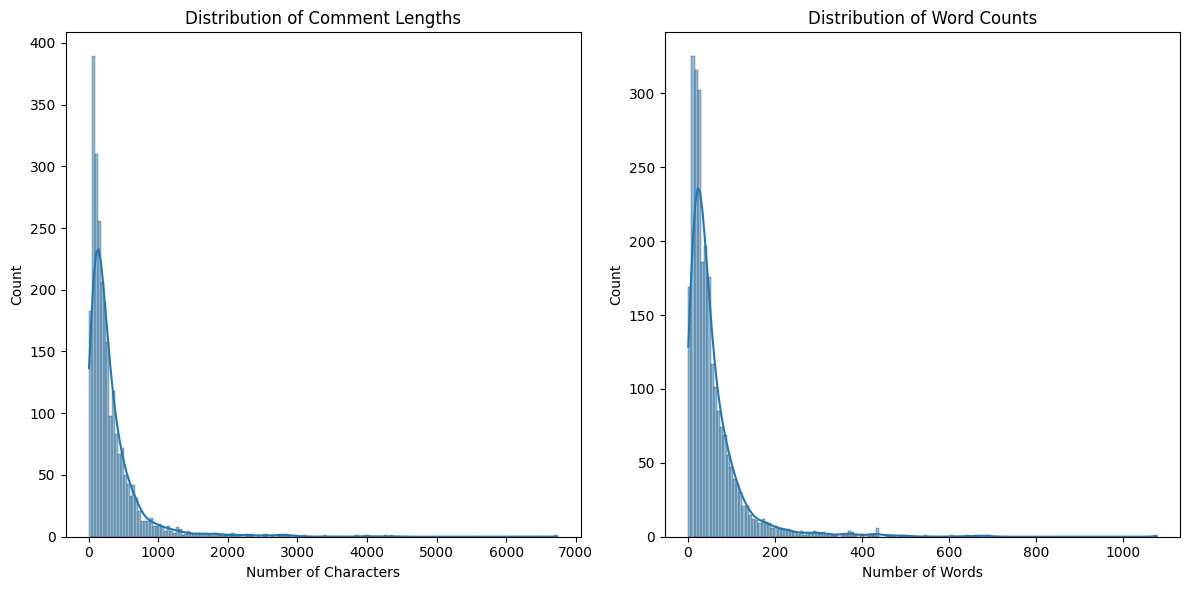

In [193]:
# Plot 3: Distribution of comment lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['comment_length'], kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

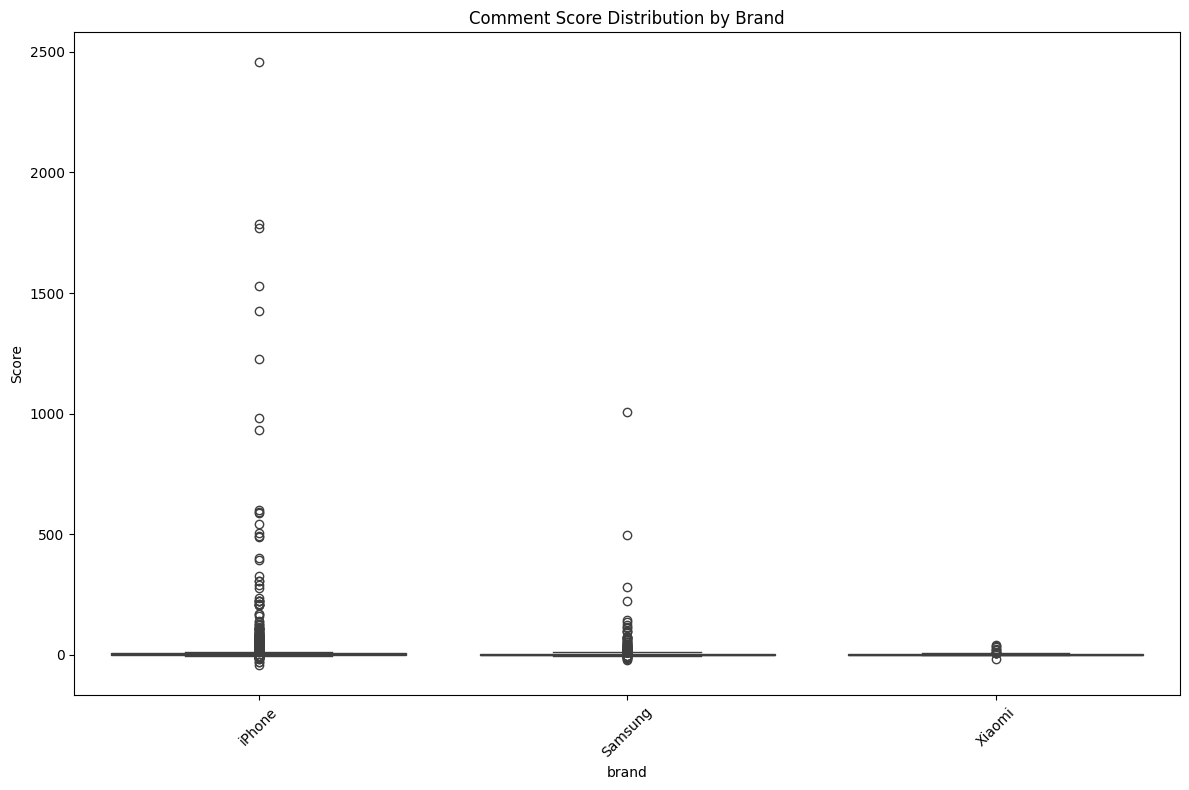

In [194]:
# Plot 4: Comment score distribution by brand
plt.figure(figsize=(12, 8))
sns.boxplot(x='brand', y='comment_score', data=df)
plt.title('Comment Score Distribution by Brand')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Tiền xử lý dữ liệu

In [195]:
# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

### 2.1. Kiểm tra dữ liệu thiếu và trùng lặp

In [196]:
# ## 1. Kiểm tra dữ liệu thiếu và loại bỏ duplicate
print("\n== Kiểm tra và làm sạch dữ liệu ==")

# Kiểm tra giá trị null
print("----- Handling Missing Values -----")
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")

if missing_values.sum() > 0:
    initial_count = len(df)
    processed_df = df.dropna(subset=['comment_body'])
    print(f"Removed {initial_count - len(df)} rows with missing comment_body")

# Kiểm tra các bình luận trùng lặp
print("\n----- Removing Duplicates -----")
duplicates = df.duplicated(subset=['comment_body']).sum()
print(f"\nSố lượng bình luận trùng lặp: {duplicates}")

# Loại bỏ các bình luận trùng lặp
df = df.drop_duplicates(subset=['comment_body'])
print(f"Kích thước dữ liệu sau khi loại bỏ duplicate: {df.shape}")


== Kiểm tra và làm sạch dữ liệu ==
----- Handling Missing Values -----
Total missing values: 0

----- Removing Duplicates -----

Số lượng bình luận trùng lặp: 6
Kích thước dữ liệu sau khi loại bỏ duplicate: (2544, 11)


### 2.2. Phân tích sơ bộ về độ dài comment


== Phân tích độ dài bình luận ==
Thống kê về độ dài bình luận:
       comment_length  comment_word_count
count     2544.000000         2544.000000
mean       328.284198           57.777123
std        436.074381           73.317598
min          8.000000            1.000000
25%        100.000000           19.000000
50%        203.000000           37.000000
75%        384.000000           69.000000
max       6734.000000         1076.000000


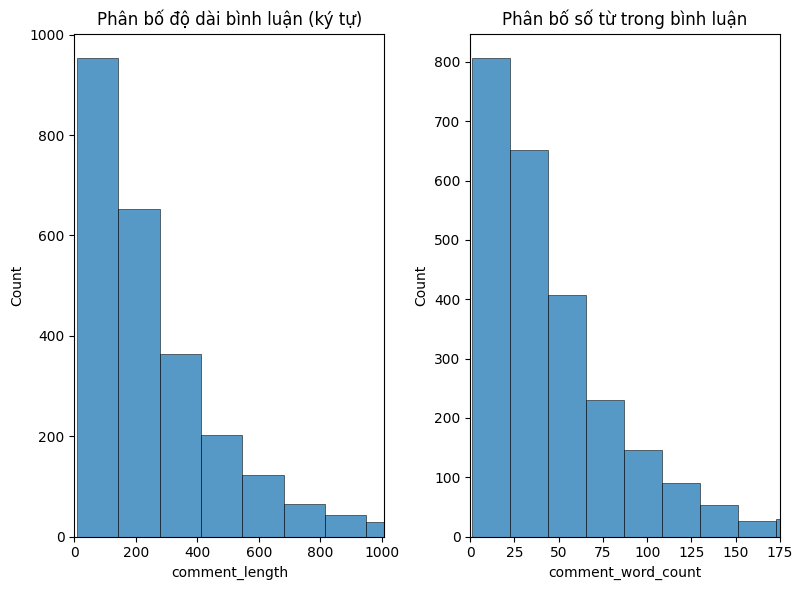

Đã lưu biểu đồ phân bố độ dài bình luận


In [197]:
# ## 2. Phân tích sơ bộ về độ dài bình luận
print("\n== Phân tích độ dài bình luận ==")

# Thêm cột độ dài bình luận
df['comment_length'] = df['comment_body'].apply(len)
df['comment_word_count'] = df['comment_body'].apply(lambda x: len(str(x).split()))

# Thống kê về độ dài
print("Thống kê về độ dài bình luận:")
print(df[['comment_length', 'comment_word_count']].describe())

# Vẽ biểu đồ phân bố độ dài
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['comment_length'], bins=50)
plt.title('Phân bố độ dài bình luận (ký tự)')
plt.xlim(0, df['comment_length'].quantile(0.95))

plt.subplot(1, 2, 2)
sns.histplot(df['comment_word_count'], bins=50)
plt.title('Phân bố số từ trong bình luận')
plt.xlim(0, df['comment_word_count'].quantile(0.95))
plt.tight_layout()
plt.show()
print("Đã lưu biểu đồ phân bố độ dài bình luận")

Cả hai biểu đồ đều cho thấy rằng phần lớn bình luận trong dữ liệu có độ dài và số từ tương đối ngắn

### 2.3. Chuyển đổi emoji

In [198]:
# ## 3. Chuyển đổi emoji
# Trích emoji ra thành list (dễ quan sát hơn)
def extract_emojis_list(text):
    """Trích xuất emoji dưới dạng list từ chuỗi văn bản"""
    if not isinstance(text, str):
        return []
    return [char for char in text if char in emoji.EMOJI_DATA]

# Thêm cột emojis_list
df['emojis_list'] = df['comment_body'].apply(extract_emojis_list)

# Lọc các bình luận có emoji
df_with_emoji = df[df['emojis_list'].apply(lambda x: len(x) > 0)]

# In thử một số mẫu có emoji
print("📌 Một số ví dụ bình luận có emoji:\n")
for i, (_, row) in enumerate(df_with_emoji.head(2).iterrows()):
    print(f"🔹 Bình luận {i+1}:")
    print("  Nội dung:", row['comment_body'][:150], "...")
    print("  Emoji tìm thấy:", " ".join(row['emojis_list']))
    print()

# Tổng số emoji
total_emojis = sum(len(e_list) for e_list in df['emojis_list'])
print(f"📊 Tổng số emoji được tìm thấy trong toàn bộ dữ liệu: {total_emojis}")

📌 Một số ví dụ bình luận có emoji:

🔹 Bình luận 1:
  Nội dung: So he is now manipulating individual stocks for him and his buddies to profit off of. Pretty bold to just openly yank stock prices up and down buying  ...
  Emoji tìm thấy: 🤔

🔹 Bình luận 2:
  Nội dung: Yep if iphones and McDonald's become more expensive we will have a revolution on our hands 😂 ...
  Emoji tìm thấy: 😂

📊 Tổng số emoji được tìm thấy trong toàn bộ dữ liệu: 101


In [199]:
# Hàm thay thế emoji bằng tên mô tả (dạng :face_with_tears_of_joy:) và lưu lại cặp thay thế
def replace_emojis_with_text_verbose(text):
    if not isinstance(text, str):
        return text, []

    replaced = []
    new_text = ""
    for char in text:
        if char in emoji.EMOJI_DATA:
            emoji_text = emoji.demojize(char, language='en')
            replaced.append((char, emoji_text))
            new_text += emoji_text
        else:
            new_text += char
    return new_text, replaced

# Áp dụng lên cột 'comment_body'
df[['comment_body_with_emoji_text', 'emoji_replacements']] = df['comment_body'].apply(
    lambda x: pd.Series(replace_emojis_with_text_verbose(x))
)

# In thử một số ví dụ
print("📌 Một số ví dụ bình luận sau khi thay emoji bằng mô tả:\n")
for i, (_, row) in enumerate(df[df['emoji_replacements'].apply(len) > 0].head(2).iterrows()):
    print(f"🔹 Bình luận {i+1}:")
    print("  🔸 Trước:\n  ", row['comment_body'][:200], "...")
    print("  🔸 Sau khi thay:\n  ", row['comment_body_with_emoji_text'][:200], "...")
    print("  🔸 Emoji đã thay:")
    for emoji_char, emoji_text in row['emoji_replacements']:
        print(f"     ➜ '{emoji_char}'  →  '{emoji_text}'")
    print()

📌 Một số ví dụ bình luận sau khi thay emoji bằng mô tả:

🔹 Bình luận 1:
  🔸 Trước:
   So he is now manipulating individual stocks for him and his buddies to profit off of. Pretty bold to just openly yank stock prices up and down buying up the dips. I thought a president couldn't enrich ...
  🔸 Sau khi thay:
   So he is now manipulating individual stocks for him and his buddies to profit off of. Pretty bold to just openly yank stock prices up and down buying up the dips. I thought a president couldn't enrich ...
  🔸 Emoji đã thay:
     ➜ '🤔'  →  ':thinking_face:'

🔹 Bình luận 2:
  🔸 Trước:
   Yep if iphones and McDonald's become more expensive we will have a revolution on our hands 😂 ...
  🔸 Sau khi thay:
   Yep if iphones and McDonald's become more expensive we will have a revolution on our hands :face_with_tears_of_joy: ...
  🔸 Emoji đã thay:
     ➜ '😂'  →  ':face_with_tears_of_joy:'



### 2.4. Tiền xử lý dữ liệu

In [200]:
# ## 4. Tiền xử lý văn bản
print("\n== Tiền xử lý văn bản (Cải tiến cho phân tích cảm xúc) ==")

# Tạo danh sách các từ phủ định cần giữ lại
negation_words = {'not', 'no', 'never', 'none', 'neither', 'nor', 'nothing', 'nowhere', 'hardly', 'barely', 'scarcely', 'doesn', 'isn', 'wasn', 'shouldn', 'wouldn', 'couldn', 'won', 'don'}

# Tạo danh sách stopwords nhưng loại bỏ các từ phủ định
custom_stopwords = set(stopwords.words('english'))
custom_stopwords = {word for word in custom_stopwords if word not in negation_words}

# Hàm tiền xử lý cải tiến cho phân tích cảm xúc
def preprocess_text_enhanced(text):
    """Hàm tiền xử lý văn bản được cải tiến cho phân tích cảm xúc"""
    if not isinstance(text, str):
        return ""

    # Chuyển về chữ thường
    text = text.lower()

    # Xử lý từ phủ định đặc biệt - thêm dấu _ để giữ liên kết ngữ nghĩa
    # Ví dụ: "not good" -> "not_good"
    negation_pattern = r'\b(' + '|'.join(negation_words) + r')\s+(\w+)'
    text = re.sub(negation_pattern, r'\1_\2', text)

    # Loại bỏ URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Loại bỏ HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Loại bỏ các tài khoản người dùng (như @username)
    text = re.sub(r'@\w+', '', text)

    # Thay thế số bằng token <NUM>
    text = re.sub(r'\d+', ' <NUM> ', text)

    # Xử lý dấu câu đặc biệt để phân tích cảm xúc
    text = re.sub(r'!+', ' <EXCLAMATION> ', text)  # nhiều dấu chấm than
    text = re.sub(r'\?+', ' <QUESTION> ', text)    # nhiều dấu hỏi

    # Loại bỏ các ký tự đặc biệt còn lại (giữ lại dấu space)
    text = re.sub(r'[^\w\s<>_]', ' ', text)

    # Tokenization đơn giản
    tokens = text.split()

    # Loại bỏ stopwords, nhưng giữ lại từ phủ định
    tokens = [word for word in tokens if word not in custom_stopwords]

    # Lemmatization (không áp dụng cho từ phủ định kết hợp và tokens đặc biệt)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) if not (word.startswith('<') or '_' in word) else word
             for word in tokens]

    # Loại bỏ các từ quá ngắn, trừ tokens đặc biệt và từ phủ định kết hợp
    tokens = [word for word in tokens if len(word) > 2 or word.startswith('<') or '_' in word]

    # Ghép lại thành văn bản
    processed_text = ' '.join(tokens)

    return processed_text

import contractions

def expand_contractions(text):
    if not isinstance(text, str):
        return text
    return contractions.fix(text)

# Áp dụng trước khi các bước khác trong preprocess_text_enhanced
df['comment_body_with_emoji_text'] = df['comment_body_with_emoji_text'].apply(expand_contractions)

print("Tiến hành tiền xử lý văn bản cải tiến...")
# Áp dụng hàm tiền xử lý mới cho cột comment_body
df['processed_comment'] = df['comment_body_with_emoji_text'].apply(preprocess_text_enhanced)

# Hiển thị ví dụ trước và sau khi xử lý
samples = df[['comment_body_with_emoji_text', 'processed_comment']].head(5)
for i, row in samples.iterrows():
    print(f"\nVí dụ {i+1}:")
    print("Trước khi xử lý:", row['comment_body_with_emoji_text'][:200], "..." if len(row['comment_body_with_emoji_text']) > 200 else "")
    print("Sau khi xử lý:", row['processed_comment'][:200], "..." if len(row['processed_comment']) > 200 else "")


== Tiền xử lý văn bản (Cải tiến cho phân tích cảm xúc) ==
Tiến hành tiền xử lý văn bản cải tiến...

Ví dụ 1:
Trước khi xử lý: Has anyone else noticed that FB now suggests *everyone* in your contacts  — without a way for you to control access to your contacts?  

I go rarely but did notice that behavior just recently. Checked ...
Sau khi xử lý: anyone else noticed suggests everyone contact without way control access contact <QUESTION> rarely notice behavior recently checked iphone setting not_use laptop no_control access phone contact find l ...

Ví dụ 2:
Trước khi xử lý: Anyone not rich enough to buy an iPhone gets to pay extra tax. MAGA! 
Sau khi xử lý: anyone not_rich enough buy iphone get pay extra tax maga <EXCLAMATION> 

Ví dụ 3:
Trước khi xử lý: Reddit has been total shit since whatever they did to the feeds. It used to have a feed of general interest subs. Now I can choose my home feed, which does not even show posts from most subs I have jo ...
Sau khi xử lý: reddit total shit

### 2.5. Lọc các commnet rỗng sau khi xử lý

In [201]:
# ## 5. Lọc các bình luận rỗng sau khi xử lý
print("\n== Lọc bình luận rỗng ==")

# Đếm số bình luận rỗng sau khi xử lý
empty_comments = df['processed_comment'].apply(lambda x: len(str(x).strip()) == 0).sum()
print(f"Số bình luận rỗng sau khi xử lý: {empty_comments}")

# Lọc bỏ các bình luận rỗng
df = df[df['processed_comment'].apply(lambda x: len(str(x).strip()) > 0)]
print(f"Kích thước dữ liệu sau khi lọc: {df.shape}")

# Kiểm tra độ dài sau khi xử lý
df['processed_length'] = df['processed_comment'].apply(len)
df['processed_word_count'] = df['processed_comment'].apply(lambda x: len(str(x).split()))

print("\nThống kê sau khi xử lý:")
print(df[['processed_length', 'processed_word_count']].describe())


== Lọc bình luận rỗng ==
Số bình luận rỗng sau khi xử lý: 8
Kích thước dữ liệu sau khi lọc: (2536, 16)

Thống kê sau khi xử lý:
       processed_length  processed_word_count
count       2536.000000           2536.000000
mean         216.106467             31.205047
std          292.908213             40.981159
min            3.000000              1.000000
25%           70.000000             10.000000
50%          133.500000             19.500000
75%          250.000000             36.000000
max         4695.000000            635.000000


### 2.6. Phân tích các từ phổ biến


== Phân tích các từ phổ biến ==
20 từ phổ biến nhất:
<NUM>: 4434
iphone: 1908
apple: 1043
phone: 887
samsung: 852
<QUESTION>: 734
would: 715
like: 596
year: 523
iphones: 496
one: 439
people: 434
pro: 434
get: 402
new: 380
still: 357
price: 350
also: 333
android: 323
make: 322

Tạo word cloud...


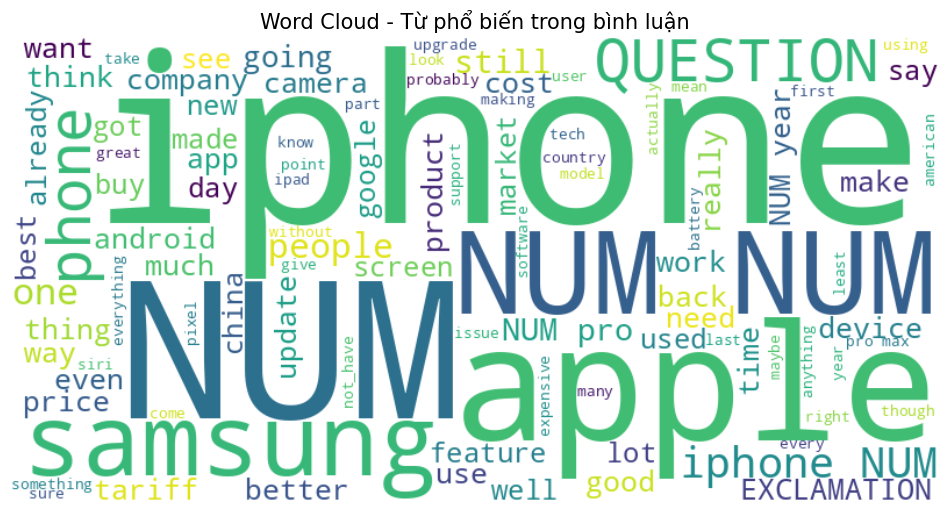

In [202]:
# ## 6. Phân tích các từ phổ biến
print("\n== Phân tích các từ phổ biến ==")

# Tính tần suất xuất hiện của các từ
all_words = ' '.join(df['processed_comment']).split()
word_counts = Counter(all_words)

# Hiển thị 20 từ phổ biến nhất
print("20 từ phổ biến nhất:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

# Vẽ word cloud
print("\nTạo word cloud...")
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(' '.join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Từ phổ biến trong bình luận', fontsize=15)
plt.show()

 Biểu đồ cho thấy người dùng chủ yếu thảo luận về các sản phẩm như iPhone và Samsung, các tính năng của điện thoại, giá cả và các vấn đề liên quan đến pin.

### 2.7. Bổ sung các đặc trưng cảm xúc mới

In [203]:
# ## 7.Thêm các đặc trưng cảm xúc mới
print("\n== Thêm đặc trưng cảm xúc ==")

# Đếm số lượng dấu chấm than và dấu hỏi trong văn bản gốc
df['exclamation_count'] = df['comment_body'].apply(lambda x: str(x).count('!') if isinstance(x, str) else 0)
df['question_count'] = df['comment_body'].apply(lambda x: str(x).count('?') if isinstance(x, str) else 0)

# Đếm số lượng emoji
df['emoji_count'] = df['emojis_list'].apply(len)

# Đếm số từ in hoa (có thể biểu thị nhấn mạnh)
df['uppercase_word_count'] = df['comment_body'].apply(
    lambda x: len([w for w in str(x).split() if w.isupper() and len(w) > 1]) if isinstance(x, str) else 0
)

# Hiển thị thống kê về các đặc trưng mới
print("\nThống kê về các đặc trưng cảm xúc mới:")
print(df[['exclamation_count', 'question_count', 'emoji_count', 'uppercase_word_count']].describe())


== Thêm đặc trưng cảm xúc ==

Thống kê về các đặc trưng cảm xúc mới:
       exclamation_count  question_count  emoji_count  uppercase_word_count
count        2536.000000     2536.000000  2536.000000           2536.000000
mean            0.107256        0.308754     0.039826              1.032334
std             0.634581        0.730633     0.301853              3.114726
min             0.000000        0.000000     0.000000              0.000000
25%             0.000000        0.000000     0.000000              0.000000
50%             0.000000        0.000000     0.000000              0.000000
75%             0.000000        0.000000     0.000000              1.000000
max            15.000000       12.000000     6.000000             87.000000


### 2.8. Lưu dữ liệu đã tiền xử lý

In [204]:
# Chuẩn bị các cột để lưu
columns_to_save = ['brand', 'subreddit', 'post_id', 'post_title', 'comment_id',
                    'comment_body', 'comment_score', 'comment_time', 'comment_author',
                    'processed_comment', 'processed_word_count',
                    'exclamation_count', 'question_count', 'emoji_count', 'uppercase_word_count']

output_df = df[columns_to_save].copy()
# Lưu với tên khác để phân biệt
output_df.to_csv('/content/drive/MyDrive/BTL_Data_Mining/Dataset/processed/preprocessed_reddit_comments_enhanced.csv', index=False)
print("\nEnhanced preprocessed data saved to 'preprocessed_reddit_comments_enhanced.csv'")


Enhanced preprocessed data saved to 'preprocessed_reddit_comments_enhanced.csv'


## 3. Gán nhãn dữ liệu

In [205]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Nếu chưa tải bộ từ điển của VADER thì chạy lệnh này:
nltk.download('vader_lexicon')

# Khởi tạo đối tượng phân tích cảm xúc
sid = SentimentIntensityAnalyzer()

# Hàm tính điểm cảm xúc (compound score)
def get_sentiment_score(text):
    if not isinstance(text, str):
        return 0
    score = sid.polarity_scores(text)['compound']
    return score

# Hàm gán nhãn cảm xúc từ điểm số
def assign_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Áp dụng lên cột 'processed_comment'
df['sentiment_score'] = df['processed_comment'].apply(get_sentiment_score)
df['sentiment'] = df['sentiment_score'].apply(assign_sentiment_label)

# In thử kết quả
print("\n📌 Một số ví dụ gán nhãn cảm xúc bằng VADER:\n")
for i, row in df[['processed_comment', 'sentiment_score', 'sentiment']].head(5).iterrows():
    print(f"🔹 Bình luận {i+1}:")
    print("  Nội dung:", row['processed_comment'][:150], "...")
    print("  → Điểm cảm xúc:", row['sentiment_score'])
    print("  → Nhãn cảm xúc:", row['sentiment'])
    print()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



📌 Một số ví dụ gán nhãn cảm xúc bằng VADER:

🔹 Bình luận 1:
  Nội dung: anyone else noticed suggests everyone contact without way control access contact <QUESTION> rarely notice behavior recently checked iphone setting not ...
  → Điểm cảm xúc: -0.296
  → Nhãn cảm xúc: negative

🔹 Bình luận 2:
  Nội dung: anyone not_rich enough buy iphone get pay extra tax maga <EXCLAMATION> ...
  → Điểm cảm xúc: -0.1027
  → Nhãn cảm xúc: negative

🔹 Bình luận 3:
  Nội dung: reddit total shit since whatever feed used feed general interest sub choose home feed not_even show post sub joined instead show stuff sub recently vi ...
  → Điểm cảm xúc: -0.4404
  → Nhãn cảm xúc: negative

🔹 Bình luận 4:
  Nội dung: mac likely iphone photo storage icloud likely way user would built use window work fine one drive <NUM> never_use ...
  → Điểm cảm xúc: 0.2023
  → Nhãn cảm xúc: positive

🔹 Bình luận 5:
  Nội dung: considering said driver not_available message played tried call thinking driver accidentally pressed v

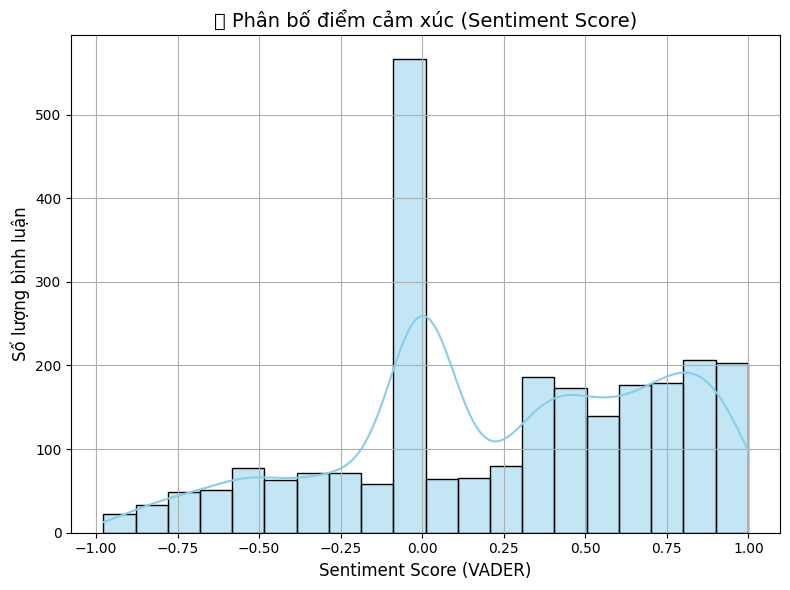

In [206]:
# Visualize sentiment distribution using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment_score'], bins=20, kde=True, color='skyblue')

plt.title('📈 Phân bố điểm cảm xúc (Sentiment Score)', fontsize=14)
plt.xlabel('Sentiment Score (VADER)', fontsize=12)
plt.ylabel('Số lượng bình luận', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

 Biểu đồ này cho thấy phần lớn các bình luận trong bộ dữ liệu có cảm xúc trung tính với ít bình luận rõ ràng tích cực hoặc tiêu cực. Điều này có thể phản ánh một sự phân bố cảm xúc cân bằng, nơi người dùng chia sẻ quan điểm mà không có cảm xúc quá mạnh mẽ.


In [207]:
df.sentiment.value_counts()

,count
sentiment,
positive,1457
neutral,558
negative,521


In [208]:
# Lưu dữ liệu đã gán nhãn ra file CSV mới
df.to_csv('/content/drive/MyDrive/BTL_Data_Mining/Dataset/processed/reddit_comments_with_sentiment.csv', index=False, encoding='utf-8-sig')
print("✅ Đã lưu dữ liệu đã gán nhãn vào file reddit_comments_with_sentiment.csv")

✅ Đã lưu dữ liệu đã gán nhãn vào file reddit_comments_with_sentiment.csv


## 4. EDA

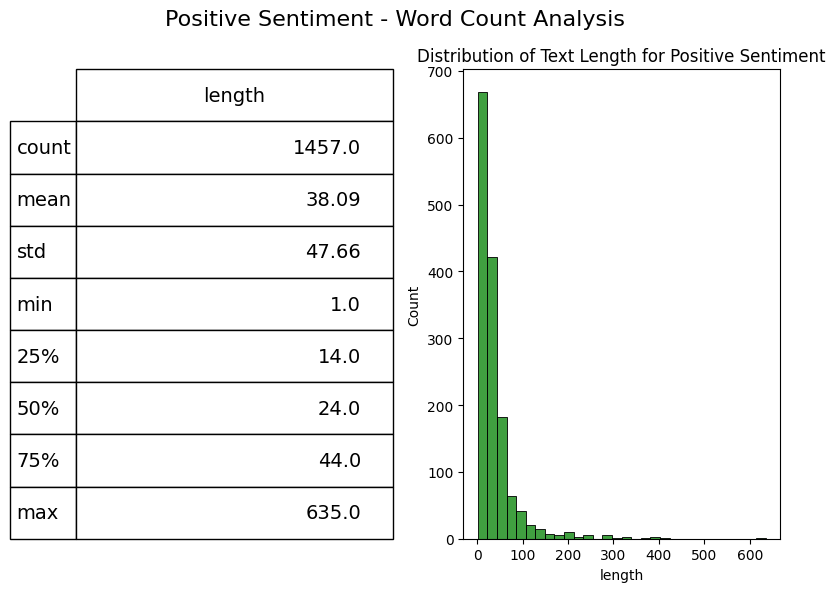

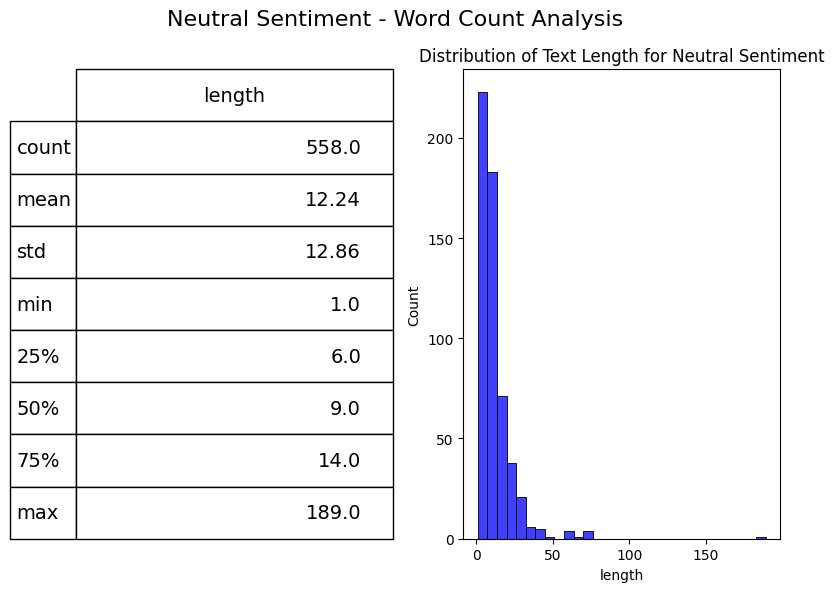

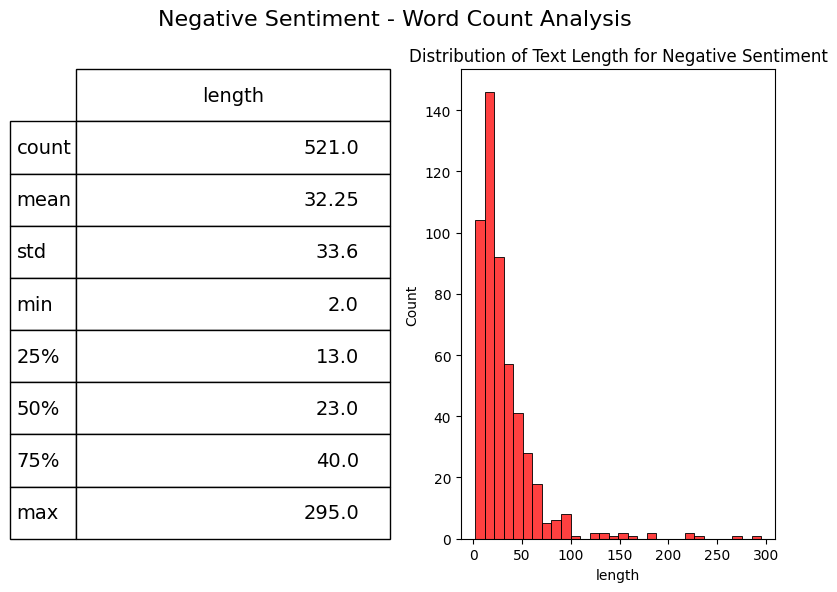

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính độ dài (số từ) của bình luận đã xử lý
df['length'] = df['processed_comment'].str.split().apply(len)

# Thiết lập màu và tiêu đề cho từng nhóm cảm xúc
sentiment_groups = {
    'positive': {'color': 'green', 'title': 'Positive Sentiment'},
    'neutral': {'color': 'blue', 'title': 'Neutral Sentiment'},
    'negative': {'color': 'red', 'title': 'Negative Sentiment'}
}

# Duyệt qua từng nhóm cảm xúc để vẽ
for sentiment, config in sentiment_groups.items():
    fig = plt.figure(figsize=(8, 6))

    # Lọc dữ liệu theo nhãn
    sentiment_data = df[df['sentiment'] == sentiment]
    desc = sentiment_data['length'].describe().round(2).to_frame()

    # Bảng mô tả
    ax1 = fig.add_subplot(121)
    ax1.axis('off')
    table = ax1.table(cellText=desc.values,
                      rowLabels=desc.index,
                      colLabels=desc.columns,
                      bbox=[0, 0, 1, 1])
    table.set_fontsize(14)

    # Biểu đồ phân bố độ dài
    ax2 = fig.add_subplot(122)
    sns.histplot(sentiment_data['length'], ax=ax2, color=config['color'], bins=30)
    ax2.set_title(f'Distribution of Text Length for {config["title"]}')

    plt.suptitle(f'{config["title"]} - Word Count Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()




*   Biểu đồ về `Positive` cho thấy phần lớn các bình luận tích cực trong dữ liệu có độ dài ngắn, nhưng có một số ít bình luận rất dài. Điều này có thể phản ánh xu hướng người dùng đưa ra nhận xét ngắn gọn và tích cực về sản phẩm hoặc chủ đề, mặc dù cũng có những bình luận dài để mô tả chi tiết cảm xúc tích cực của họ

*   Biểu đồ về `Neutral` cho thấy phần lớn các bình luận trung lập trong dữ liệu có độ dài ngắn, với một số ít bình luận dài. Điều này phản ánh xu hướng người dùng chia sẻ quan điểm trung lập một cách nhanh chóng và ngắn gọn

*   Biểu đồ về `Negative` cho thấy phần lớn các bình luận tiêu cực có độ dài ngắn, nhưng vẫn tồn tại một số bình luận dài hơn. Điều này có thể phản ánh rằng người dùng thường chia sẻ cảm xúc tiêu cực ngắn gọn, mặc dù có những bình luận dài khi cần giải thích chi tiết cảm xúc của họ.







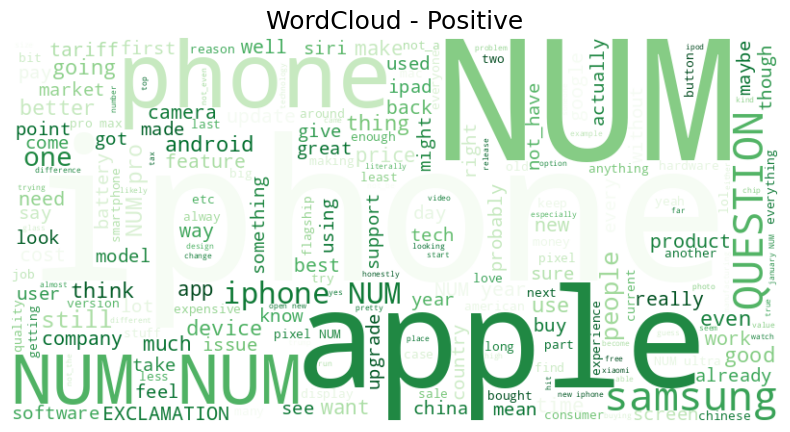

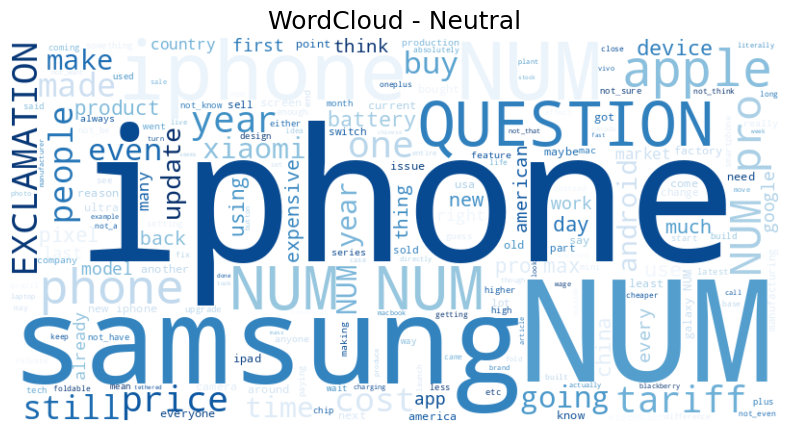

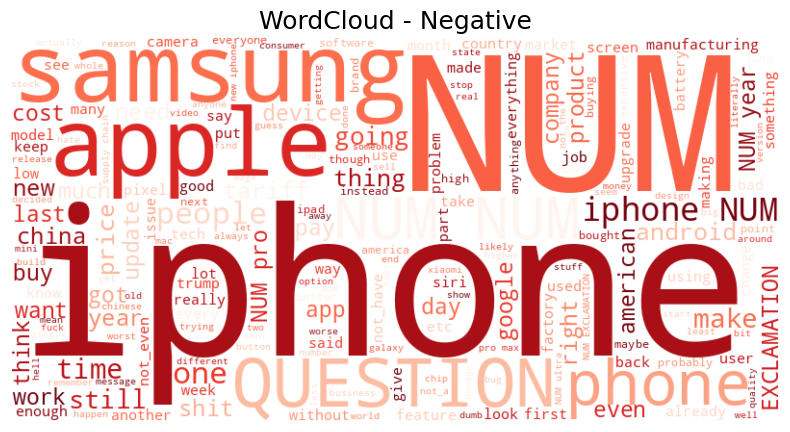

In [210]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Thiết lập cấu hình từng nhãn
sentiment_configs = {
    'positive': {'color': 'Greens', 'title': 'WordCloud - Positive'},
    'neutral':  {'color': 'Blues',  'title': 'WordCloud - Neutral'},
    'negative': {'color': 'Reds',   'title': 'WordCloud - Negative'}
}

# Tạo wordcloud cho từng loại nhãn
for sentiment, config in sentiment_configs.items():
    # Nối toàn bộ văn bản của nhãn đó lại thành 1 chuỗi
    text = ' '.join(df[df['sentiment'] == sentiment]['processed_comment'])

    # Tạo WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=config['color'],
        max_words=200
    ).generate(text)

    # Hiển thị WordCloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(config['title'], fontsize=18)
    plt.tight_layout()
    plt.show()




*   Cảm xúc tích cực: Chủ yếu liên quan đến sự hài lòng với các sản phẩm như iPhone và Apple.

*   Cảm xúc trung lập: Chủ yếu là thảo luận và so sánh giữa các sản phẩm, không có cảm xúc rõ ràng.

*   Cảm xúc tiêu cực: Liên quan đến sự thất vọng và chỉ trích các sản phẩm, đặc biệt là iPhone và Samsung.


In [211]:
import plotly.express as px

# Vẽ pie chart cho cột 'sentiment'
fig = px.pie(
    df,
    names='sentiment',
    title='📊 Phân bố tỷ lệ cảm xúc trong dữ liệu Reddit',
    hole=0.3  # tạo Donut chart nếu muốn, bỏ nếu bạn thích Pie truyền thống
)

# Hiển thị
fig.show()


Biểu đồ cho thấy phần lớn các bình luận trên Reddit có cảm xúc tích cực, với một tỷ lệ nhỏ cảm xúc tiêu cực và trung lập. Điều này có thể phản ánh xu hướng chung của người dùng khi tham gia vào các thảo luận trực tuyến về sản phẩm hoặc chủ đề cụ thể.


## 5. Trích xuất đặc trưng

In [212]:
def evaluate(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"== {name} ==")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return model.score(X_test, y_test)

In [213]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Giả sử df1 đã có sẵn
le = LabelEncoder()
df1 = df.copy()
df1['label'] = le.fit_transform(df1['sentiment'])
y = df1['label']

# BoW
bow_vectorizer = CountVectorizer(max_features=3000)
X_bow = bow_vectorizer.fit_transform(df1['processed_comment'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(df1['processed_comment'])

# Handcrafted features
df1['length'] = df1['processed_comment'].str.split().apply(len)
df1['num_exclamation'] = df1['processed_comment'].str.count('<EXCLAMATION>')
df1['num_question'] = df1['processed_comment'].str.count('<QUESTION>')
df1['num_num'] = df1['processed_comment'].str.count('<NUM>')
X_handcrafted = df1[['length', 'num_exclamation', 'num_question', 'num_num']].values

# Kết hợp
X_tfidf_hand = np.hstack([X_tfidf.toarray(), X_handcrafted])
X_bow_hand = np.hstack([X_bow.toarray(), X_handcrafted])

In [214]:
print("Bag of Words Features:")
print(X_bow[:2])

Bag of Words Features:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 39 stored elements and shape (2, 3000)>
  Coords	Values
  (0, 117)	2
  (0, 728)	1
  (0, 1854)	1
  (0, 2603)	1
  (0, 787)	1
  (0, 515)	3
  (0, 2957)	1
  (0, 2911)	1
  (0, 522)	1
  (0, 10)	2
  (0, 2133)	2
  (0, 2152)	1
  (0, 1853)	1
  (0, 2183)	1
  (0, 408)	1
  (0, 1294)	1
  (0, 2402)	1
  (0, 1832)	1
  (0, 1347)	1
  (0, 1980)	1
  (0, 917)	1
  (0, 1385)	1
  (0, 1334)	1
  (0, 1573)	1
  (0, 2500)	1
  (0, 1201)	1
  (0, 919)	1
  (0, 500)	1
  (0, 36)	1
  (1, 117)	1
  (1, 1294)	1
  (1, 746)	1
  (1, 341)	1
  (1, 1044)	1
  (1, 1955)	1
  (1, 846)	1
  (1, 2652)	1
  (1, 1464)	1
  (1, 801)	1


In [215]:
print("TF-IDF Features:")
print(X_tfidf[:2])

TF-IDF Features:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 39 stored elements and shape (2, 3000)>
  Coords	Values
  (0, 117)	0.2541581822385708
  (0, 728)	0.12618932343764303
  (0, 1854)	0.16547292903310498
  (0, 2603)	0.18808778230306383
  (0, 787)	0.12067467368898013
  (0, 515)	0.5519202436084298
  (0, 2957)	0.11464776754471458
  (0, 2911)	0.10078735372453244
  (0, 522)	0.13953342710398073
  (0, 10)	0.29999449891286245
  (0, 2133)	0.13676744429929208
  (0, 2152)	0.1929540465149922
  (0, 1853)	0.16745091221321678
  (0, 2183)	0.14603583659915997
  (0, 408)	0.16958729680002552
  (0, 1294)	0.04098515470328727
  (0, 2402)	0.1381283364457657
  (0, 1832)	0.17445356101195392
  (0, 1347)	0.14026472103257442
  (0, 1980)	0.0663556158398943
  (0, 917)	0.12449411515465579
  (0, 1385)	0.13552231114353935
  (0, 1334)	0.11021085133652962
  (0, 1573)	0.17445356101195392
  (0, 2500)	0.10973422155126421
  (0, 1201)	0.14999724945643123
  (0, 919)	0.18040938706443832
  (0, 500)	0.160

In [216]:
print("Handcrafted Features (First 5 rows):")
print(df1[['length', 'num_exclamation', 'num_question', 'num_num']].head())

Handcrafted Features (First 5 rows):
   length  num_exclamation  num_question  num_num
0      39                0             2        0
1      11                1             0        0
2      69                0             0        1
3      19                0             0        1
4      32                0             0        0


In [217]:
print("Shape of TF-IDF + Handcrafted Features:", X_tfidf_hand.shape)
print(X_tfidf_hand[:10])

Shape of TF-IDF + Handcrafted Features: (2536, 3004)
[[0. 0. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 3. 1.]]


In [218]:
print("Shape of BoW + Handcrafted Features:", X_bow_hand.shape)
print(X_bow_hand[:10])

Shape of BoW + Handcrafted Features: (2536, 3004)
[[0 0 0 ... 0 2 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 1]]


In [219]:
scores = {}
scores['BoW'] = evaluate(X_bow, y, "Bag-of-Words")
scores['TF-IDF'] = evaluate(X_tfidf, y, "TF-IDF")
scores['Handcrafted'] = evaluate(X_handcrafted, y, "Handcrafted Features")
scores['TF-IDF+Hand'] = evaluate(X_tfidf_hand, y, "TF-IDF + Handcrafted")
scores['BoW+Hand'] = evaluate(X_bow_hand, y, "BoW + Handcrafted")

best = max(scores, key=scores.get)
print("\n== Kết luận ==")
print(f"Đặc trưng phù hợp nhất với dữ liệu này là: {best} (score: {scores[best]:.4f})")


== Bag-of-Words ==
              precision    recall  f1-score   support

    negative       0.69      0.44      0.54       122
     neutral       0.61      0.66      0.63       118
    positive       0.76      0.85      0.80       268

    accuracy                           0.71       508
   macro avg       0.69      0.65      0.66       508
weighted avg       0.71      0.71      0.70       508

== TF-IDF ==
              precision    recall  f1-score   support

    negative       0.86      0.15      0.25       122
     neutral       0.72      0.41      0.52       118
    positive       0.61      0.96      0.75       268

    accuracy                           0.64       508
   macro avg       0.73      0.51      0.51       508
weighted avg       0.70      0.64      0.58       508

== Handcrafted Features ==
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       122
     neutral       0.61      0.47      0.53       118
    positive    

## 6. Xây dựng mô hình

In [220]:
df['label'] = le.fit_transform(df['sentiment'])
y = df['label']

# BoW + Hand
bow_vectorizer = CountVectorizer(max_features=3000)
X_bow = bow_vectorizer.fit_transform(df['processed_comment'])
X_bow_hand = np.hstack([X_bow.toarray(), X_handcrafted])
X_train, X_test, y_train, y_test = train_test_split(X_bow_hand, y, test_size=0.2, random_state=42)

### 6.1. S.d thư viện

In [221]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Giả sử X_bow_hand, y, le đã có từ các bước trước
X_train, X_test, y_train, y_test = train_test_split(X_bow_hand, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB()
}

best_score = 0
best_model = None
best_name = ""

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f"\n== {name} ==")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    if score > best_score:
        best_score = score
        best_model = model
        best_name = name

print(f"\n== Best Model: {best_name} (accuracy: {best_score:.4f}) ==")



== Logistic Regression ==
              precision    recall  f1-score   support

    negative       0.72      0.48      0.57       122
     neutral       0.67      0.71      0.69       118
    positive       0.76      0.86      0.81       268

    accuracy                           0.73       508
   macro avg       0.72      0.68      0.69       508
weighted avg       0.73      0.73      0.72       508


== SVM ==
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       122
     neutral       0.61      0.47      0.53       118
    positive       0.59      0.91      0.71       268

    accuracy                           0.59       508
   macro avg       0.40      0.46      0.41       508
weighted avg       0.45      0.59      0.50       508


== Random Forest ==
              precision    recall  f1-score   support

    negative       0.92      0.09      0.16       122
     neutral       0.62      0.56      0.59       118
    positive    

### 6.2. Support Vector Machine (SVM)

In [235]:
class SVM_Manual_Fast:
    def __init__(self, kernel='linear', C=1.0, gamma=0.1, degree=3, max_iter=100, tol=1e-3, class_weight=None):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.max_iter = max_iter
        self.tol = tol
        self.classes = None
        self.models = []
        self.class_weight = class_weight  # Thêm class_weight

    def _kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return linear_kernel(x1, x2)
        elif self.kernel == 'rbf':
            return rbf_kernel(x1, x2, self.gamma)
        elif self.kernel == 'poly':
            return polynomial_kernel(x1, x2, self.degree)
        else:
            raise ValueError(f"Kernel không hợp lệ: {self.kernel}")

    def _compute_kernel_matrix(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i, n_samples):
                K[i, j] = K[j, i] = self._kernel_function(X[i], X[j])
        return K

    def fit(self, X, y):
        print(f"Huấn luyện SVM với kernel={self.kernel}, C={self.C}, gamma={self.gamma}")

        # Multi-class SVM với One-vs-Rest approach
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Tính class weights nếu không được cung cấp
        if self.class_weight is None:
            # Tính class_weight tự động dựa trên số lượng mẫu (balanced)
            class_counts = np.array([np.sum(y == c) for c in self.classes])
            total_samples = len(y)
            self.class_weight = total_samples / (n_classes * class_counts)

        print("Class weights:", {c: w for c, w in zip(self.classes, self.class_weight)})

        # Tính toán kernel matrix một lần để tăng tốc (tối ưu bộ nhớ)
        print("Tính kernel matrix...")
        start_time = time.time()
        K = self._compute_kernel_matrix(X)
        print(f"Tính kernel matrix mất {time.time() - start_time:.2f}s")

        for i, c in enumerate(self.classes):
            print(f"  Huấn luyện lớp {c} ({i+1}/{n_classes})")
            # Chuyển thành bài toán nhị phân
            binary_y = np.where(y == c, 1, -1)

            # Áp dụng class weights cho bài toán nhị phân
            sample_weights = np.ones(len(y))
            sample_weights[y == c] = self.class_weight[i]  # Weight cho mẫu positive
            sample_weights[y != c] = np.mean([self.class_weight[j] for j in range(n_classes) if j != i])  # Weight trung bình cho mẫu negative

            # Khởi tạo alpha và b
            n_samples = X.shape[0]
            alphas = np.zeros(n_samples)
            b = 0

            # SMO đơn giản hóa với dừng sớm
            it = 0
            num_alpha_changes = 0
            examine_all = True

            while (it < self.max_iter) and ((num_alpha_changes > 0) or examine_all):
                num_alpha_changes = 0

                # Xác định danh sách mẫu để xem xét
                if examine_all:
                    # Xem xét tất cả điểm
                    range_i = np.random.permutation(n_samples)
                else:
                    # Chỉ xem xét các điểm có 0 < alpha < C (non-bound support vectors)
                    non_bound_idx = np.where((alphas > 0) & (alphas < self.C * sample_weights))[0]
                    if len(non_bound_idx) > 0:
                        range_i = non_bound_idx
                    else:
                        range_i = np.random.permutation(n_samples)

                # Chỉ xem xét một tập con mẫu trong mỗi vòng lặp để tăng tốc
                num_samples_to_examine = min(200, len(range_i))  # Tăng lên 200 mẫu/vòng lặp
                range_i = range_i[:num_samples_to_examine]

                # Định nghĩa non_bound_idx trước khi sử dụng trong vòng lặp
                non_bound_idx = np.where((alphas > 0) & (alphas < self.C * sample_weights))[0]

                for j in range_i:
                    # Tính lỗi
                    fj = np.sum(alphas * binary_y * K[j]) + b
                    Ej = fj - binary_y[j]

                    # Kiểm tra nếu có thể tối ưu alpha
                    if ((binary_y[j] * Ej < -self.tol and alphas[j] < self.C * sample_weights[j]) or
                        (binary_y[j] * Ej > self.tol and alphas[j] > 0)):

                        # Khởi tạo giá trị k mặc định
                        k = j

                        # Chọn second sample thông minh hơn
                        if len(non_bound_idx) > 1:
                            # Chọn k để max |E_j - E_k| nếu có > 1 non-bound SVs
                            max_error_diff = 0
                            Ek = 0

                            for idx in non_bound_idx:
                                if idx != j:
                                    fk_tmp = np.sum(alphas * binary_y * K[idx]) + b
                                    Ek_tmp = fk_tmp - binary_y[idx]
                                    error_diff = abs(Ej - Ek_tmp)

                                    if error_diff > max_error_diff:
                                        max_error_diff = error_diff
                                        k = idx
                                        Ek = Ek_tmp

                            # Nếu không tìm được k phù hợp, chọn ngẫu nhiên
                            if k == j:
                                while k == j and len(range_i) > 1:
                                    k = range_i[np.random.randint(0, len(range_i))]
                                fk = np.sum(alphas * binary_y * K[k]) + b
                                Ek = fk - binary_y[k]
                        else:
                            # Chọn k ngẫu nhiên nếu không có non-bound SVs
                            while k == j and len(range_i) > 1:
                                k = range_i[np.random.randint(0, len(range_i))]
                            fk = np.sum(alphas * binary_y * K[k]) + b
                            Ek = fk - binary_y[k]

                        # Lưu alpha cũ
                        alpha_j_old = alphas[j]
                        alpha_k_old = alphas[k]

                        # Tính giới hạn
                        if binary_y[j] != binary_y[k]:
                            L = max(0, alphas[k] - alphas[j])
                            H = min(self.C * sample_weights[k], self.C * sample_weights[j] + alphas[k] - alphas[j])
                        else:
                            L = max(0, alphas[j] + alphas[k] - self.C * sample_weights[k])
                            H = min(self.C * sample_weights[j], alphas[j] + alphas[k])

                        if L == H:
                            continue

                        # Tính eta
                        eta = 2.0 * K[j, k] - K[j, j] - K[k, k]
                        if eta >= 0:
                            continue

                        # Cập nhật alpha k
                        alphas[k] = alpha_k_old - binary_y[k] * (Ej - Ek) / eta
                        alphas[k] = min(H, alphas[k])
                        alphas[k] = max(L, alphas[k])

                        if abs(alphas[k] - alpha_k_old) < self.tol:
                            continue

                        # Cập nhật alpha j
                        alphas[j] = alpha_j_old + binary_y[j] * binary_y[k] * (alpha_k_old - alphas[k])

                        # Cập nhật b
                        b1 = b - Ej - binary_y[j] * (alphas[j] - alpha_j_old) * K[j, j] - binary_y[k] * (alphas[k] - alpha_k_old) * K[j, k]
                        b2 = b - Ek - binary_y[j] * (alphas[j] - alpha_j_old) * K[j, k] - binary_y[k] * (alphas[k] - alpha_k_old) * K[k, k]

                        if 0 < alphas[j] < self.C * sample_weights[j]:
                            b = b1
                        elif 0 < alphas[k] < self.C * sample_weights[k]:
                            b = b2
                        else:
                            b = (b1 + b2) / 2.0

                        num_alpha_changes += 1

                # Kiểm tra tiến độ
                if it % 5 == 0:
                    n_sv = np.sum((alphas > self.tol) & (alphas < self.C * sample_weights))
                    n_bound = np.sum(alphas >= self.C * sample_weights - self.tol)
                    print(f"    Lặp lại {it}: {n_sv} support vectors, {n_bound} bound points, {num_alpha_changes} thay đổi")

                # Chuyển đổi giữa examine_all và non_bound only
                if examine_all:
                    examine_all = False
                elif num_alpha_changes == 0:
                    examine_all = True

                it += 1

                # Dừng sớm nếu đã lặp đủ và không có cải thiện
                if it >= 20 and num_alpha_changes == 0:
                    print("    Dừng sớm vì đã hội tụ")
                    break

            # Tìm support vectors
            sv_indices = np.where(alphas > self.tol)[0]
            support_vectors = X[sv_indices]
            support_vector_labels = binary_y[sv_indices]
            support_vector_alphas = alphas[sv_indices]

            print(f"    Số lượng support vectors: {len(sv_indices)}")

            # Lưu model cho lớp này
            self.models.append({
                'support_vectors': support_vectors,
                'support_vector_labels': support_vector_labels,
                'alphas': support_vector_alphas,
                'b': b,
                'class': c
            })

        return self

    def predict(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes)

        # Ma trận để lưu giá trị quyết định cho mỗi lớp
        decision_values = np.zeros((n_samples, n_classes))

        # Tính giá trị quyết định cho mỗi lớp
        for i, model in enumerate(self.models):
            sv = model['support_vectors']
            sv_labels = model['support_vector_labels']
            alphas = model['alphas']
            b = model['b']

            for j in range(n_samples):
                decision_values[j, i] = np.sum([
                    alphas[k] * sv_labels[k] * self._kernel_function(X[j], sv[k])
                    for k in range(len(sv))
                ]) + b

        # Trả về lớp có giá trị quyết định cao nhất
        return self.classes[np.argmax(decision_values, axis=1)]


In [236]:
# Chuẩn hóa dữ liệu - quan trọng cho SVM
def normalize_data(X):
    X_norm = X.copy()
    for i in range(X.shape[1]):
        feature_max = np.max(np.abs(X[:, i]))
        if feature_max > 0:
            X_norm[:, i] = X[:, i] / feature_max
    return X_norm

# Định nghĩa hạt nhân (kernel) cho SVM
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

def polynomial_kernel(x1, x2, degree=3):
    return (np.dot(x1, x2) + 1) ** degree

In [237]:
# Hàm tìm tham số tối ưu - phiên bản nhanh và cân bằng hơn
def find_best_parameters_fast(X_train, y_train, X_val, y_val):
    best_acc = 0
    best_params = {'kernel': 'linear', 'C': 1.0, 'gamma': 0.1}  # Mặc định

    # Thử nhiều tham số hơn, tập trung vào rbf kernel
    param_grid = [
        {'kernel': 'linear', 'C': 1.0, 'gamma': 0.1},
        {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1},
        {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01},
        {'kernel': 'rbf', 'C': 100.0, 'gamma': 0.001},  # C lớn với gamma nhỏ thường tốt với dữ liệu có nhiều chiều
        {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1}
    ]

    # Thử với tập dữ liệu lớn hơn
    subset_size = min(800, len(X_train))  # Tăng từ 500 lên 800
    X_train_subset = X_train[:subset_size]
    y_train_subset = y_train[:subset_size]

    val_subset_size = min(300, len(X_val))  # Tăng từ 200 lên 300
    X_val_subset = X_val[:val_subset_size]
    y_val_subset = y_val[:val_subset_size]

    # Tính class weights dựa trên tần suất xuất hiện của mỗi lớp (balanced)
    classes = np.unique(y_train_subset)
    class_counts = np.array([np.sum(y_train_subset == c) for c in classes])
    n_samples = len(y_train_subset)
    class_weight = n_samples / (len(classes) * class_counts)

    for params in param_grid:
        print(f"\nThử tham số: {params}")
        start_time = time.time()

        # Sử dụng class_weight để cân bằng
        svm = SVM_Manual_Fast(
            kernel=params['kernel'],
            C=params['C'],
            gamma=params['gamma'],
            max_iter=30,  # Giảm số lần lặp xuống 30
            class_weight=class_weight  # Thêm class_weight
        )

        svm.fit(X_train_subset, y_train_subset)
        y_pred = svm.predict(X_val_subset)

        # Tính các chỉ số đánh giá
        acc = accuracy_score(y_val_subset, y_pred)
        cm = confusion_matrix(y_val_subset, y_pred)

        # Tính F1 score cho từng lớp
        report = classification_report(y_val_subset, y_pred, output_dict=True)
        f1_scores = [report[str(c)]['f1-score'] for c in classes]
        avg_f1 = np.mean(f1_scores)

        elapsed = time.time() - start_time
        print(f"Accuracy: {acc:.4f}, Avg F1: {avg_f1:.4f}, Thời gian: {elapsed:.2f}s")
        print("Confusion Matrix:")
        print(cm)

        # Sử dụng cả accuracy và F1 score để đánh giá
        combined_score = 0.5 * acc + 0.5 * avg_f1
        if combined_score > best_acc:  # Thay đổi tiêu chí đánh giá
            best_acc = combined_score
            best_params = params.copy()

    print(f"\nTham số tốt nhất: {best_params}, Combined score: {best_acc:.4f}")
    return best_params

In [238]:
print(f"Dữ liệu đã tải: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}")

# Đảm bảo dữ liệu đầu vào là ndarray, không phải pandas Series
if isinstance(y_train, pd.Series):
    print("Chuyển đổi y_train từ pandas Series sang numpy array")
    y_train = y_train.to_numpy()
if isinstance(X_train, pd.DataFrame):
    print("Chuyển đổi X_train từ pandas DataFrame sang numpy array")
    X_train = X_train.to_numpy()
if isinstance(X_test, pd.DataFrame):
    print("Chuyển đổi X_test từ pandas DataFrame sang numpy array")
    X_test = X_test.to_numpy()
if isinstance(y_test, pd.Series):
    print("Chuyển đổi y_test từ pandas Series sang numpy array")
    y_test = y_test.to_numpy()

# Sử dụng nhiều dữ liệu hơn để cải thiện độ chính xác
print("Sử dụng một phần dữ liệu để tăng tốc...")
sample_size = min(3000, X_train.shape[0])
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_train_sample = X_train[indices]
y_train_sample = y_train[indices]

# Chuẩn hóa dữ liệu
X_train_norm = normalize_data(X_train_sample)
X_test_norm = normalize_data(X_test)

# Kiểm tra phân phối các lớp trong tập huấn luyện
unique_classes, class_counts = np.unique(y_train_sample, return_counts=True)
print("\nPhân phối lớp trong tập huấn luyện:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Lớp {cls}: {count} mẫu ({count/len(y_train_sample)*100:.1f}%)")

# Tạo tập validation nhỏ
print("Tạo tập validation...")
val_size = int(0.2 * len(X_train_norm))
X_train_opt = X_train_norm[:-val_size]
y_train_opt = y_train_sample[:-val_size]
X_val = X_train_norm[-val_size:]
y_val = y_train_sample[-val_size:]

print("Tìm tham số tối ưu (phiên bản nhanh)...")
start_time = time.time()
best_params = find_best_parameters_fast(X_train_opt, y_train_opt, X_val, y_val)
print(f"Tổng thời gian tìm tham số: {time.time() - start_time:.2f}s")

# Tính class weights cho tập huấn luyện đầy đủ
classes = np.unique(y_train_sample)
class_counts = np.array([np.sum(y_train_sample == c) for c in classes])
n_samples = len(y_train_sample)
class_weight = n_samples / (len(classes) * class_counts)

# Huấn luyện mô hình SVM với tham số tối ưu
print("Huấn luyện mô hình cuối cùng với tham số tối ưu...")
start_time = time.time()
svm = SVM_Manual_Fast(
    kernel=best_params['kernel'],
    C=best_params['C'],
    gamma=best_params['gamma'],
    max_iter=50,  # Giới hạn số lần lặp
    class_weight=class_weight  # Thêm class_weight
)
svm.fit(X_train_norm, y_train_sample)
train_time = time.time() - start_time
print(f"Thời gian huấn luyện: {train_time:.2f}s")

# Dự đoán và đánh giá
print("Đánh giá trên tập test...")
start_time = time.time()
y_pred = svm.predict(X_test_norm)
test_time = time.time() - start_time
print(f"Thời gian dự đoán: {test_time:.2f}s")

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy trên tập test: {accuracy:.4f}")

# In confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# In classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

Dữ liệu đã tải: X_train: (2028, 3004), y_train: (2028,), X_test: (508, 3004)
Sử dụng một phần dữ liệu để tăng tốc...

Phân phối lớp trong tập huấn luyện:
Lớp 0: 399 mẫu (19.7%)
Lớp 1: 440 mẫu (21.7%)
Lớp 2: 1189 mẫu (58.6%)
Tạo tập validation...
Tìm tham số tối ưu (phiên bản nhanh)...

Thử tham số: {'kernel': 'linear', 'C': 1.0, 'gamma': 0.1}
Huấn luyện SVM với kernel=linear, C=1.0, gamma=0.1
Class weights: {np.int64(0): np.float64(1.6771488469601676), np.int64(1): np.float64(1.5779092702169626), np.int64(2): np.float64(0.5649717514124294)}
Tính kernel matrix...
Tính kernel matrix mất 3.09s
  Huấn luyện lớp 0 (1/3)
    Lặp lại 0: 107 support vectors, 2 bound points, 97 thay đổi
    Lặp lại 5: 95 support vectors, 11 bound points, 91 thay đổi
    Lặp lại 10: 95 support vectors, 11 bound points, 0 thay đổi
    Lặp lại 15: 192 support vectors, 21 bound points, 62 thay đổi
    Lặp lại 20: 170 support vectors, 33 bound points, 20 thay đổi
    Lặp lại 25: 157 support vectors, 41 bound points,

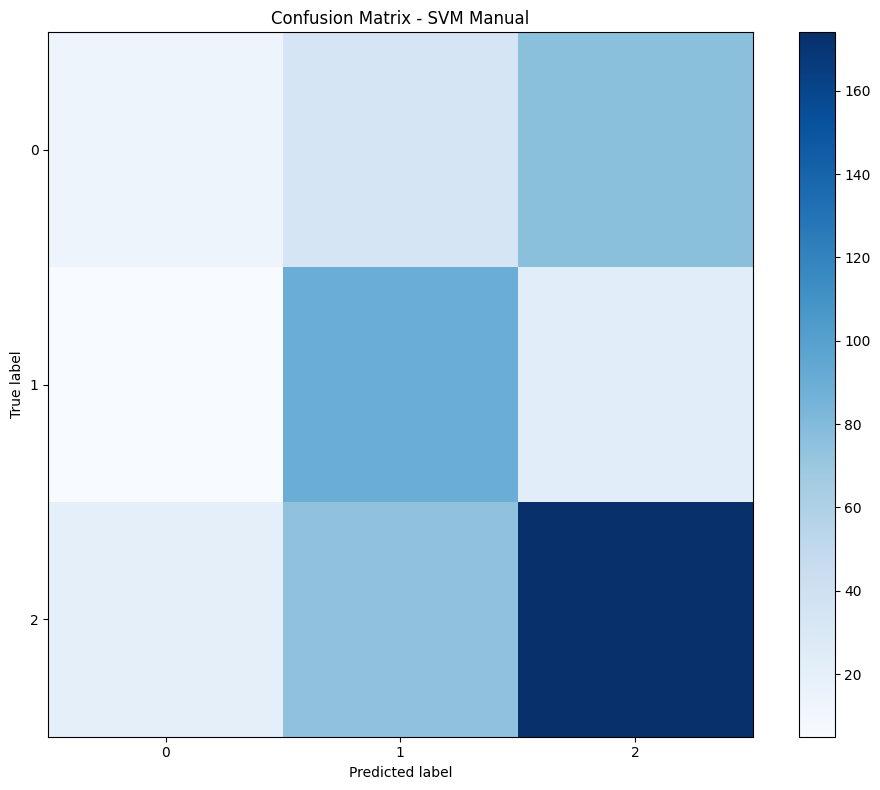


Lưu mô hình Support Vector Machine (SVM)...
Đã lưu mô hình vào file 'svm_model.pkl'
SVM Manual đã chạy xong!


In [239]:
# Vẽ biểu đồ confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SVM Manual')
plt.colorbar()

classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Lưu mô hình
print("\nLưu mô hình Support Vector Machine (SVM)...")
with open('/content/drive/MyDrive/BTL_Data_Mining/Dataset/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
print("Đã lưu mô hình vào file 'svm_model.pkl'")

print("SVM Manual đã chạy xong!")

### 6.3. Logistic Regression

In [227]:
# Cài đặt Logistic Regression
class LogisticRegression_Manual_Fast:
    def __init__(self, learning_rate=0.01, max_iter=500, tol=1e-4, C=1.0, batch_size=128):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.C = C  # Regularization parameter
        self.batch_size = batch_size  # Mini-batch size
        self.weights = None
        self.bias = None
        self.classes = None
        self.feature_means = None  # Lưu trung bình của các đặc trưng
        self.feature_stds = None   # Lưu độ lệch chuẩn của các đặc trưng

    def sigmoid(self, z):
        # Clip để tránh overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        # Clip và sử dụng trick ổn định hóa
        z = np.clip(z, -500, 500)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Lưu thông số chuẩn hóa
        self.feature_means = np.mean(X, axis=0)
        self.feature_stds = np.std(X, axis=0)

        # Khởi tạo weights và bias
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        # One-hot encoding cho y
        y_one_hot = np.zeros((n_samples, n_classes))
        for i, c in enumerate(self.classes):
            y_one_hot[:, i] = (y == c).astype(int)

        # Mini-batch Gradient Descent
        n_batches = max(1, n_samples // self.batch_size)
        prev_loss = float('inf')

        for iteration in range(self.max_iter):
            # Shuffle dữ liệu mỗi epoch
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_one_hot_shuffled = y_one_hot[indices]

            total_loss = 0

            # Duyệt qua các mini-batch
            for batch in range(n_batches):
                start_idx = batch * self.batch_size
                end_idx = min((batch + 1) * self.batch_size, n_samples)

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_one_hot_shuffled[start_idx:end_idx]
                batch_size = end_idx - start_idx

                # Forward pass
                linear_output = np.dot(X_batch, self.weights) + self.bias
                y_pred = self.softmax(linear_output)

                # Tính loss
                batch_loss = -np.mean(np.sum(y_batch * np.log(y_pred + 1e-15), axis=1))
                batch_loss += (self.C / (2 * batch_size)) * np.sum(self.weights ** 2)  # L2 regularization
                total_loss += batch_loss * batch_size

                # Backward pass - tính gradient
                error = y_pred - y_batch

                # Update weights và bias
                dw = (1 / batch_size) * np.dot(X_batch.T, error) + (self.C / batch_size) * self.weights
                db = (1 / batch_size) * np.sum(error, axis=0)

                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Tính average loss cho epoch
            avg_loss = total_loss / n_samples

            # Early stopping
            if abs(prev_loss - avg_loss) < self.tol:
                print(f"Hội tụ sau {iteration+1} vòng lặp. Loss: {avg_loss:.6f}")
                break

            prev_loss = avg_loss

            if iteration % 20 == 0:
                print(f"Lặp {iteration}, Loss: {avg_loss:.6f}")

            # Dừng sớm nếu đã chạy nhiều vòng lặp
            if iteration >= 100:
                print(f"Dừng sớm sau {iteration+1} vòng lặp")
                break

        return self

    def normalize_new_data(self, X):
        """Chuẩn hóa dữ liệu mới sử dụng thông số đã lưu"""
        X_norm = X.copy()
        for i in range(X.shape[1]):
            if self.feature_stds[i] > 0:
                X_norm[:, i] = (X[:, i] - self.feature_means[i]) / self.feature_stds[i]
        return X_norm

    def predict_proba(self, X):
        # Nếu có thông số chuẩn hóa, áp dụng chuẩn hóa cho dữ liệu đầu vào
        if hasattr(self, 'feature_means') and hasattr(self, 'feature_stds'):
            X = self.normalize_new_data(X)

        linear_output = np.dot(X, self.weights) + self.bias
        return self.softmax(linear_output)

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes[np.argmax(probas, axis=1)]

In [228]:
# Hàm tìm tham số tối ưu - phiên bản nhanh
def find_best_parameters_fast(X_train, y_train, X_val, y_val):
    best_acc = 0
    best_params = {'learning_rate': 0.1, 'C': 1.0, 'max_iter': 200}  # Mặc định

    # Chỉ thử số lượng tham số giới hạn
    param_grid = [
        {'learning_rate': 0.1, 'C': 1.0, 'max_iter': 200},
        {'learning_rate': 0.01, 'C': 0.1, 'max_iter': 200},
        {'learning_rate': 0.1, 'C': 10.0, 'max_iter': 200}
    ]

    # Sử dụng tập con nhỏ hơn để tăng tốc quá trình tìm kiếm
    subset_size = min(500, len(X_train))
    X_train_subset = X_train[:subset_size]
    y_train_subset = y_train[:subset_size]

    val_subset_size = min(200, len(X_val))
    X_val_subset = X_val[:val_subset_size]
    y_val_subset = y_val[:val_subset_size]

    for params in param_grid:
        print(f"\nThử tham số: {params}")
        start_time = time.time()

        logistic = LogisticRegression_Manual_Fast(
            learning_rate=params['learning_rate'],
            C=params['C'],
            max_iter=params['max_iter'],
            batch_size=64  # Batch size nhỏ để tăng tốc
        )

        logistic.fit(X_train_subset, y_train_subset)
        y_pred = logistic.predict(X_val_subset)
        acc = accuracy_score(y_val_subset, y_pred)

        elapsed = time.time() - start_time
        print(f"Accuracy: {acc:.4f}, Thời gian: {elapsed:.2f}s")

        if acc > best_acc:
            best_acc = acc
            best_params = params.copy()

    print(f"\nTham số tốt nhất: {best_params}, accuracy: {best_acc:.4f}")
    return best_params

In [229]:
# Chuẩn hóa dữ liệu
def normalize_data(X):
    X_norm = X.copy()
    for i in range(X.shape[1]):
        feature_mean = np.mean(X[:, i])
        feature_std = np.std(X[:, i])
        if feature_std > 0:
            X_norm[:, i] = (X[:, i] - feature_mean) / feature_std
    return X_norm

print(f"Dữ liệu đã tải: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}")

# Đảm bảo dữ liệu đầu vào là ndarray, không phải pandas Series
if isinstance(y_train, pd.Series):
    print("Chuyển đổi y_train từ pandas Series sang numpy array")
    y_train = y_train.to_numpy()
if isinstance(X_train, pd.DataFrame):
    print("Chuyển đổi X_train từ pandas DataFrame sang numpy array")
    X_train = X_train.to_numpy()
if isinstance(X_test, pd.DataFrame):
    print("Chuyển đổi X_test từ pandas DataFrame sang numpy array")
    X_test = X_test.to_numpy()
if isinstance(y_test, pd.Series):
    print("Chuyển đổi y_test từ pandas Series sang numpy array")
    y_test = y_test.to_numpy()

# Sử dụng tập con dữ liệu để tăng tốc
print("Sử dụng một phần dữ liệu để tăng tốc...")
sample_size = min(2000, X_train.shape[0])  # Tối đa 2000 mẫu
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_train_sample = X_train[indices]
y_train_sample = y_train[indices]

# Chuẩn hóa dữ liệu
X_train_norm = normalize_data(X_train_sample)
X_test_norm = normalize_data(X_test)

# Tạo tập validation nhỏ
print("Tạo tập validation...")
val_size = int(0.2 * len(X_train_norm))
X_train_opt = X_train_norm[:-val_size]
y_train_opt = y_train_sample[:-val_size]
X_val = X_train_norm[-val_size:]
y_val = y_train_sample[-val_size:]

print("Tìm tham số tối ưu (phiên bản nhanh)...")
start_time = time.time()
best_params = find_best_parameters_fast(X_train_opt, y_train_opt, X_val, y_val)
print(f"Tổng thời gian tìm tham số: {time.time() - start_time:.2f}s")

# Huấn luyện mô hình cuối cùng với tham số tối ưu
print("Huấn luyện mô hình cuối cùng với tham số tối ưu...")
start_time = time.time()
logistic = LogisticRegression_Manual_Fast(
    learning_rate=best_params['learning_rate'],
    C=best_params['C'],
    max_iter=best_params['max_iter'],
    batch_size=128  # Batch size lớn hơn cho mô hình cuối cùng
)
logistic.fit(X_train_norm, y_train_sample)
train_time = time.time() - start_time
print(f"Thời gian huấn luyện: {train_time:.2f}s")

# Đánh giá trên tập test
print("Đánh giá trên tập test...")
start_time = time.time()
y_pred = logistic.predict(X_test_norm)
test_time = time.time() - start_time
print(f"Thời gian dự đoán: {test_time:.2f}s")

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy trên tập test: {accuracy:.4f}")

# In confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# In classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

Dữ liệu đã tải: X_train: (2028, 3004), y_train: (2028,), X_test: (508, 3004)
Sử dụng một phần dữ liệu để tăng tốc...
Tạo tập validation...
Tìm tham số tối ưu (phiên bản nhanh)...

Thử tham số: {'learning_rate': 0.1, 'C': 1.0, 'max_iter': 200}
Lặp 0, Loss: 0.858396
Lặp 20, Loss: 0.111341
Lặp 40, Loss: 0.096873
Lặp 60, Loss: 0.093868
Lặp 80, Loss: 0.090028
Hội tụ sau 85 vòng lặp. Loss: 0.088754
Accuracy: 0.5700, Thời gian: 1.55s

Thử tham số: {'learning_rate': 0.01, 'C': 0.1, 'max_iter': 200}
Lặp 0, Loss: 0.926274
Lặp 20, Loss: 0.293683
Lặp 40, Loss: 0.202919
Hội tụ sau 55 vòng lặp. Loss: 0.169215
Accuracy: 0.5700, Thời gian: 0.88s

Thử tham số: {'learning_rate': 0.1, 'C': 10.0, 'max_iter': 200}
Lặp 0, Loss: 0.942406
Lặp 20, Loss: 0.291065
Hội tụ sau 24 vòng lặp. Loss: 0.296911
Accuracy: 0.5750, Thời gian: 0.47s

Tham số tốt nhất: {'learning_rate': 0.1, 'C': 10.0, 'max_iter': 200}, accuracy: 0.5750
Tổng thời gian tìm tham số: 2.90s
Huấn luyện mô hình cuối cùng với tham số tối ưu...
Lặp 0

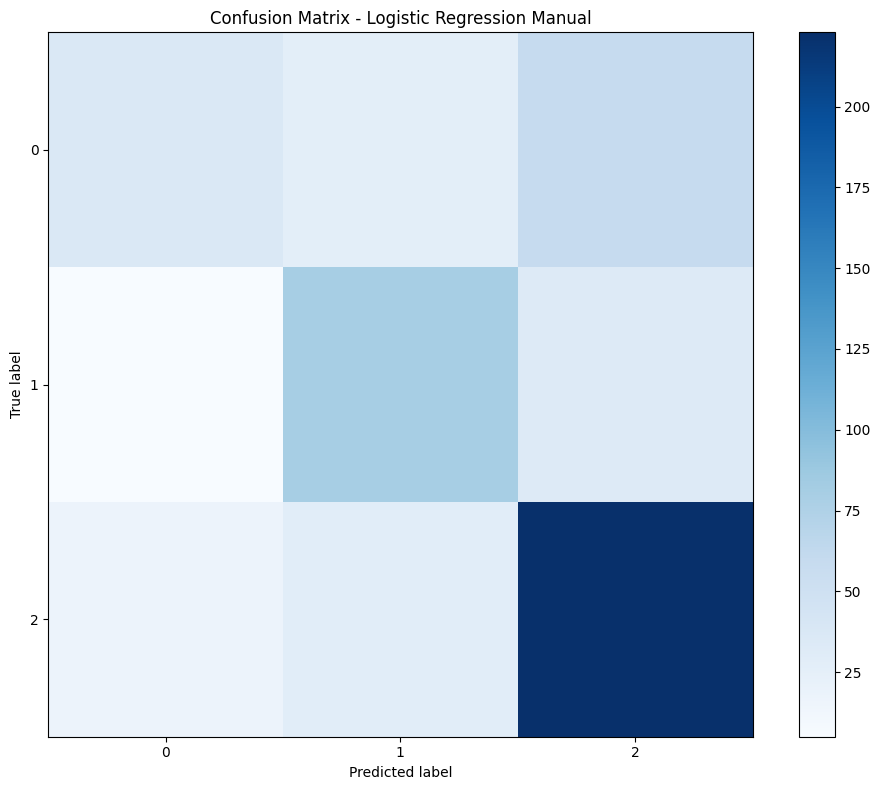

In [230]:
# Vẽ confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression Manual')
plt.colorbar()

classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [231]:
# Kiểm tra feature importance
if logistic.weights is not None:
    feature_importance = np.sum(np.abs(logistic.weights), axis=1)
    top_features_idx = np.argsort(feature_importance)[-10:]  # Giảm xuống 10 features
    print("\nTop 10 features quan trọng nhất:")

    for i, idx in enumerate(reversed(top_features_idx)):
        print(f"Feature {idx}: {feature_importance[idx]:.4f}")

print("Logistic Regression Manual đã hoàn thành!")

# Lưu mô hình
print("\nLưu mô hình Logistic Regression...")
with open('/content/drive/MyDrive/BTL_Data_Mining/Dataset/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(logistic, f)
print("Đã lưu mô hình vào file 'logistic_regression_model.pkl'")


Top 10 features quan trọng nhất:
Feature 1133: 0.3374
Feature 1395: 0.3350
Feature 1425: 0.3066
Feature 1443: 0.3058
Feature 2417: 0.2794
Feature 249: 0.2735
Feature 2989: 0.2499
Feature 1062: 0.2469
Feature 691: 0.2443
Feature 2927: 0.2385
Logistic Regression Manual đã hoàn thành!

Lưu mô hình Logistic Regression...
Đã lưu mô hình vào file 'logistic_regression_model.pkl'


## 7. Demo mô hình

In [ ]:
# Hàm tạo đặc trưng thủ công cho 1 câu
def handcrafted_features(comment):
    length = len(comment.split())
    num_exclamation = comment.count('<EXCLAMATION>')
    num_question = comment.count('<QUESTION>')
    num_num = comment.count('<NUM>')
    return np.array([[length, num_exclamation, num_question, num_num]])

while True:
    new_comment = input("Nhập bình luận (hoặc gõ 'exit' để thoát): ").strip()
    if new_comment.lower() == "exit":
        break

    # Vector hóa BoW
    X_bow_new = bow_vectorizer.transform([new_comment])
    # Đặc trưng thủ công
    X_handcrafted_new = handcrafted_features(new_comment)
    # Kết hợp
    X_bow_hand_new = np.hstack([X_bow_new.toarray(), X_handcrafted_new])

    # Dự đoán xác suất
    if hasattr(best_model, "predict_proba"):
        probs = best_model.predict_proba(X_bow_hand_new)[0]
    else:
        print("Model không hỗ trợ dự đoán xác suất. Đang dự đoán nhãn thôi.")
        probs = None

    pred_label = best_model.predict(X_bow_hand_new)[0]
    sentiment_pred = le.inverse_transform([pred_label])[0]

    if probs is not None:
        for idx, cls in enumerate(le.classes_):
            print(f"{cls}: {probs[idx]*100:.2f}%")
        print(f"Kết luận: Bình luận có cảm xúc '{sentiment_pred}' với độ tin cậy {np.max(probs)*100:.2f}%")
    else:
        print(f"Kết luận: Bình luận có cảm xúc '{sentiment_pred}'")

    print("-" * 40)


Nhập bình luận (hoặc gõ 'exit' để thoát): “We have a about a zillion iPhones in a Chinese warehouse and need a few weeks to get those in, or we will start calling for your head”
negative: 70.63%
neutral: 1.56%
positive: 27.81%
Kết luận: Bình luận có cảm xúc 'negative' với độ tin cậy 70.63%
----------------------------------------
Nhập bình luận (hoặc gõ 'exit' để thoát): "We're naming this one iphone '47... its never been done before"
negative: 25.26%
neutral: 37.42%
positive: 37.32%
Kết luận: Bình luận có cảm xúc 'neutral' với độ tin cậy 37.42%
----------------------------------------
Nhập bình luận (hoặc gõ 'exit' để thoát): exit
